# Analysis on Learning Smooth Neural Functions via Lipschitz Regularization 
reference: https://nv-tlabs.github.io/lip-mlp/ 

# Introduction
Lipschitz-constrained networks are now a useful technique used in deep learning. It has a good performance on robust to adversarial attacks. 

Consider a function to be k-Lipschitz: 
\begin{align}
||f(x1) - f(x2)|| <= k * ||x1 - x2||
\end{align}
Where k is the Lipschitz constant. 

The change in f is bounded by the change in x. When k is small, the small change in x will result in a small change in f as well. 


---
In *Learning Smooth Neural Functions via Lipschitz Regularization*,  LIU proposed a new method to smooth the latent space in the Neural field by adding constrain on the Lipschitz constant. Instead of straightly bound on the Lipschitz constant, this method makes k a learnable factor and minimizes it. 

\begin{align}
||f(t1) - f(t2)|| <= k * ||t1 - t2||
\end{align}

In this analysis, the latent space is time. The purpose is to train a neural network that is smooth to its latent code t. That is a small change in t results in a small change to the output as well.

I will examine its performance both in 2D and 3D, and compare it with a nueral network without weight normalization and a k-Lipschitz constrained networks. 


## Environment set up


In [ ]:
!pip install trimesh
!pip install --upgrade jax jaxlib
!pip install rtree
!pip install pyrender


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Model
copyright: https://github.com/ml-for-gp/jaxgptoolbox by HTDerekLi

###Normal MLP

In [ ]:
import sys
sys.path.append('../../../')


import jax
import jax.numpy as np
from jax import jit, value_and_grad


import numpy as onp
import numpy.random as random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tqdm
import pickle

class mlp:
  def __init__(self, hyperParams):
    self.hyperParams = hyperParams
  
  def initialize_weights(self):
    """
    Initialize the parameters of the Lipschitz mlp
    Inputs
    hyperParams: hyper parameter dictionary
    Outputs
    params_net: parameters of the network (weight, bias, initial lipschitz bound)
    """
    def init_W(size_out, size_in): 
        W = onp.random.randn(size_out, size_in) * onp.sqrt(2 / size_in)
        return np.array(W)
    sizes = self.hyperParams["h_mlp"]
    sizes.insert(0, self.hyperParams["dim_in"] + self.hyperParams["dim_t"])
    sizes.append(self.hyperParams["dim_out"])
    params_net = []    
    for ii in range(len(sizes) - 1):
        W = init_W(sizes[ii+1], sizes[ii])
        b = np.zeros(sizes[ii+1])
        params_net.append([W, b])
    return params_net


  def forward_single(self, params_net, t, x):
    """
    Forward pass of a lipschitz MLP
    
    Inputs
    params_net: parameters of the network
    t: the input feature of the shape
    x: a query location in the space
    Outputs
    out: implicit function value at x
    """
    # concatenate coordinate and latent code
    x = np.append(x, t)

    # forward pass
    for ii in range(len(params_net) - 1):
        W, b = params_net[ii]
        x = jax.nn.relu(np.dot(W, x) + b)

    # final layer
    W, b = params_net[-1] 
    out = np.dot(W, x) + b
    return out[0]
  forward = jax.vmap(forward_single, in_axes=(None, None, None, 0), out_axes=0)


  def forward_eval_single(self, params_final, t, x):
    """
    (Optional) this is a standard forward pass of a mlp. This is useful to speed up the performance during test time 
    """
    # concatenate coordinate and latent code
    x = np.append(x, t)

    # forward pass
    for ii in range(len(params_final) - 1):
        W, b = params_final[ii]
        x = jax.nn.relu(np.dot(W, x) + b)
    W, b = params_final[-1] # final layer
    out = np.dot(W, x) + b
    return out[0]
  forward_eval = jax.vmap(forward_eval_single, in_axes=(None, None, None, 0), out_axes=0)


###Lipschitz Regulation
As we want the Lipschitz to be as smaller as possible, and $k = \prod||W_i||_p.$

We make constrain on W to ensure k to be small.  
The difference with the normal MLP is adding the weight normalization.
By resetting weight:
\begin{align}
W_i^* = normalization(W_i, softplus(k)) 
\end{align}
where $softplus(k) = ln(1 + e^{k_i}).$ 
With the softplus function, constant k can never be negative. 

In this model, it uses infinite norm and scale each row of Wi to have the absolute value row-sum less than or equal to softplus(k). And add a Lipschitz term in loss function. 
By adding term: 
\begin{align}
L = L(normal MLP) + α* \prod sofrplus(k_i) 
\end{align}


In [ ]:
import sys
sys.path.append('../../../')


import jax
import jax.numpy as np
from jax import jit, value_and_grad


import numpy as onp
import numpy.random as random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tqdm
import pickle
from numpy import linalg as LA
class lipmlp:
  def __init__(self, hyperParams):
    self.hyperParams = hyperParams
  
  def initialize_weights(self):
    """
    Initialize the parameters of the Lipschitz mlp
    Inputs
    hyperParams: hyper parameter dictionary
    Outputs
    params_net: parameters of the network (weight, bias, initial lipschitz bound)
    """
    def init_W(size_out, size_in): 
        W = onp.random.randn(size_out, size_in) * onp.sqrt(2 / size_in)
        return np.array(W)
    sizes = self.hyperParams["h_mlp"]
    sizes.insert(0, self.hyperParams["dim_in"] + self.hyperParams["dim_t"])
    sizes.append(self.hyperParams["dim_out"])
    params_net = []    
    for ii in range(len(sizes) - 1):
        W = init_W(sizes[ii+1], sizes[ii])
        b = np.zeros(sizes[ii+1])
        c = np.max(np.sum(np.abs(W), axis=1))
        params_net.append([W, b, c])
    return params_net

  def weight_normalization(self, W, softplus_c):
    """
    Lipschitz weight normalization based on the L-infinity norm
    """
    absrowsum = np.sum(np.abs(W), axis=1)
    scale = np.minimum(1.0, softplus_c/absrowsum)
    return W * scale[:,None]

  def forward_single(self, params_net, t, x):
    """
    Forward pass of a lipschitz MLP
    
    Inputs
    params_net: parameters of the network
    t: the input feature of the shape
    x: a query location in the space
    Outputs
    out: implicit function value at x
    """
    # concatenate coordinate and latent code
    x = np.append(x, t)

    # forward pass
    for ii in range(len(params_net) - 1):
        W, b, c = params_net[ii]
        W = self.weight_normalization(W, jax.nn.softplus(c))
        x = jax.nn.relu(np.dot(W, x) + b)

    # final layer
    W, b, c = params_net[-1]
    W = self.weight_normalization(W, jax.nn.softplus(c)) 
    out = np.dot(W, x) + b
    return out[0]
  forward = jax.vmap(forward_single, in_axes=(None, None, None, 0), out_axes=0)
  
  
  def get_weight_loss(self, params_net):
    """
    This function computes the softplus loss
    """
    loss_lip = 1.0
    for ii in range(len(params_net)):
      W, b, c = params_net[ii]
      absrowsum = np.sum(np.abs(W), axis=1)
      loss_lip = loss_lip * np.max(absrowsum)  
    return loss_lip


  def get_lipschitz_loss(self, params_net):
    """
    This function computes the Lipschitz regularization
    """
    loss_lip = 1.0
    for ii in range(len(params_net)):
      W, b, c = params_net[ii]
      loss_lip = loss_lip * jax.nn.softplus(c)
    return loss_lip

  def normalize_params(self, params_net):
    """
    (Optional) After training, this function will clip network [W, b] based on learned lipschitz constants. Thus, one can use normal MLP forward pass during test time, which is a little bit faster.
    """
    params_final = []    
    for ii in range(len(params_net)):
      W, b, c = params_net[ii]
      W = self.weight_normalization(W, jax.nn.softplus(c))
      params_final.append([W, b])
    return params_final

  def forward_eval_single(self, params_final, t, x):
    """
    (Optional) this is a standard forward pass of a mlp. This is useful to speed up the performance during test time 
    """
    # concatenate coordinate and latent code
    x = np.append(x, t)

    # forward pass
    for ii in range(len(params_final) - 1):
        W, b = params_final[ii]
        x = jax.nn.relu(np.dot(W, x) + b)
    W, b = params_final[-1] # final layer
    out = np.dot(W, x) + b
    return out[0]
  forward_eval = jax.vmap(forward_eval_single, in_axes=(None, None, None, 0), out_axes=0)


## Helper function
Those are simple shapes signed distance function used as input data and grid function used in reconstruction. 

In [ ]:
#copyright: https://github.com/ml-for-gp/jaxgptoolbox by HTDerekLi
import numpy as onp
import jax.numpy as np

def sample_2D_grid(resolution, low=0, high=1):
  idx = onp.linspace(low,high,num=resolution)
  x, y = onp.meshgrid(idx, idx)
  V = onp.concatenate((x.reshape((-1,1)), y.reshape((-1,1))), 1)
  return np.array(V)

In [ ]:
import numpy as onp
import jax.numpy as np

def sample_3D_grid(resolution, low=0, high=1):
  idx = onp.linspace(low,high,num=resolution)
  x, y, z = onp.meshgrid(idx, idx, idx)
  V = onp.concatenate((x.reshape((-1, 1)), y.reshape((-1, 1)), z.reshape((-1, 1))), -1)
  return np.array(V)

In [ ]:
import numpy as onp
import jax.numpy as np



def sdf_star(x, r = 0.22):
    """
    copyright: https://github.com/ml-for-gp/jaxgptoolbox by HTDerekLi
    output the signed distance value of a star in 2D
    Inputs
    x: nx2 array of locations
    r: size of the star
    Outputs
    array of signed distance values at x
    Reference:
    https://iquilezles.org/www/articles/distfunctions2d/distfunctions2d.htm
    """
    x = onp.array(x)
    kxy = onp.array([-0.5,0.86602540378])
    kyx = onp.array([0.86602540378,-0.5])
    kz = 0.57735026919
    kw = 1.73205080757

    x = onp.abs(x - 0.5)
    x -= 2.0 * onp.minimum(x.dot(kxy), 0.0)[:,None] * kxy[None,:]
    x -= 2.0 * onp.minimum(x.dot(kyx), 0.0)[:,None] * kyx[None,:]
    x[:,0] -= onp.clip(x[:,0],r*kz,r*kw)
    x[:,1] -= r
    length_x = onp.sqrt(onp.sum(x*x, 1))
    return np.array(length_x*onp.sign(x[:,1]))

def sdf_circle(x, r = 0.282, center = np.array([0.5,0.5])):
    #copyright: https://github.com/ml-for-gp/jaxgptoolbox by HTDerekLi
    """
    output the SDF value of a circle in 2D

    Inputs
    x: nx2 array of locations
    r: radius of the circle
    center: center point of the circle

    Outputs
    array of signed distance values at x
    """
    dx = x - center
    return np.sqrt(np.sum((dx)**2, axis = 1)) - r
def sdf_2_circle(x, r1=0.282, r2=0.1, center0=np.array([0.5, 0.5]), center1=np.array([0.5, 0.5])):
    """
    output the SDF value of a circle with hole in 2D

    Inputs
    x: nx2 array of locations
    r1: radius of the larger circle
    r2: radius of the smaller circle
    center: center point of the circle

    Outputs
    array of signed distance values at x
    """
    sdf_1 = sdf_circle(x, r=r1, center=center0)
    sdf_2 = sdf_circle(x, r=r2, center=center1)

    sign_1 = onp.sign(sdf_1)
    sign_2 = onp.sign(sdf_2)
    sign_f = onp.ones(sdf_1.shape)

    result = onp.minimum(sdf_1, sdf_2)
    sign = sign_1 + sign_2
    
    sign_f[onp.where(sign == -2)] = -1
    
    result = onp.multiply(sign, result)
    index = onp.where(sign == 0)
    for i in index:
        result[i] = -1 * onp.abs(result[i])

    return result

def sdf_sphere(x, r = 0.3, center = np.array([0.5,0.5,0.5])):
    """
    output the SDF value of a sphere in 3D

    Inputs
    x: nx3 array of locations
    r: radius of the sphere
    center: center point of the sphere

    Outputs
    array of signed distance values at x
    """
    dx = x - center
    return np.sqrt(np.sum((dx)**2, axis = 1)) - r


def sdf_box(x, size = [0.5, 0.3, 0.2], center=np.array([0.5, 0.5, 0.5])):
    """
    output the SDF value of a cube in 3D

    Inputs
    x: nx3 array of locations
    r: radius of the circle
    center: center point of the circle

    Outputs
    array of signed distance values at x
    """
    cx = center[0] * onp.ones((x.shape[0], 1))
    cy = center[1] * onp.ones((x.shape[0], 1))
    cz = center[2] * onp.ones((x.shape[0], 1))
    sx = size[0] * onp.ones((x.shape[0], 1))
    sy = size[1] * onp.ones((x.shape[0], 1))
    sz = size[2] * onp.ones((x.shape[0], 1))
    xx = onp.reshape(x[:, 0], (x.shape[0], 1))
    xy = onp.reshape(x[:, 1], (x.shape[0], 1))
    xz = onp.reshape(x[:, 2], (x.shape[0], 1))
    temp1 = xx - cx - sx / 2.0
    temp2 = cx - xx - sx / 2.0
    sdf_x = onp.maximum(temp1, temp2)
    temp1 = xy - cy - sy / 2.0
    temp2 = cy - xy - sy / 2.0
    sdf_y = onp.maximum(temp1, temp2)
    temp1 = xz - cz - sz / 2.0
    temp2 = cz - xz - sz / 2.0
    sdf_z = onp.maximum(temp1, temp2)
    result = sdf_x
    result = onp.maximum(result, sdf_y)
    result = onp.maximum(result, sdf_z)
    return result.reshape(result.size)
import random as rn
def sdf_2_circle_0(num_points, r1=0.282, r2=0.1, center=onp.array([0.5, 0.5])):
    r = [r1, r2]
    result = []
    random_s = [-1, 1]
    points = rn.choices(r, k=num_points)
    for point in points:
        point_x = onp.random.uniform(0, point**2)
        point_y = point**2 - point_x

        sign = rn.choices(random_s)
        point_x = onp.sqrt(point_x) * sign[0]
        point_x = center[0] + point_x

        sign = rn.choices(random_s)
        point_y = onp.sqrt(point_y) * sign[0]
        point_y = center[1] + point_y

        result.append([point_x, point_y])
    return onp.array(result)

def sdf_torus(x, R = 0.3, r = 0.1, center=np.array([0.5, 0.5, 0.5])):
  cx = center[0] * onp.ones((x.shape[0], 1))
  cy = center[1] * onp.ones((x.shape[0], 1))
  cz = center[2] * onp.ones((x.shape[0], 1))

  a = onp.sqrt((x[:, 0] - cx) ** 2 + (x[:, 2] - cz) ** 2) - R
  return onp.sqrt(a ** 2 + (x[:, 1] - cy) ** 2) - r

##Normal MLP (2D)

100%|██████████| 20000/20000 [01:48<00:00, 183.60it/s, loss=0.000702906]


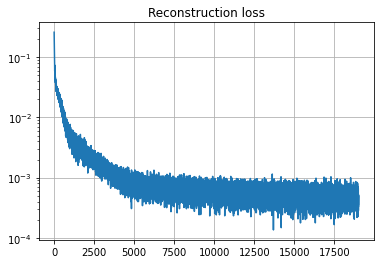

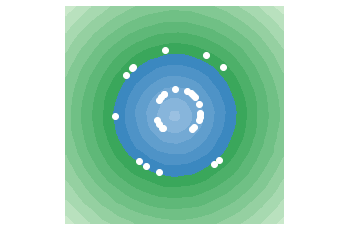

In [ ]:
from jax.example_libraries import optimizers

if __name__ == '__main__':
  random.seed(1)

  # hyper parameters
  hyper_params = {
    "dim_in": 2,
    "dim_t": 1,
    "dim_out": 1,
    "h_mlp": [64,64,64,64],
    "step_size": 1e-4,
    "grid_size": 32,
    "num_epochs": 20000,
    "samples_per_epoch": 512
  }

  # initialize a mlp
  model = mlp(hyper_params)
  params = model.initialize_weights()

  # optimizer
  opt_init, opt_update, get_params = optimizers.adam(step_size=hyper_params["step_size"])
  opt_state = opt_init(params)

  # define loss function and update function
  def loss(params_, x_, y0_, y1_):
    out0 = model.forward(params_, np.array([0.0]), x_) # star when t = 0.0
    out1 = model.forward(params_, np.array([1.0]), x_) # circle when t = 1.0
    loss_sdf = np.mean((out0 - y0_)**2) + np.mean((out1 - y1_)**2)
    return loss_sdf

  @jit
  def update(epoch, opt_state, x_, y0_, y1_):
    params_ = get_params(opt_state)
    value, grads = value_and_grad(loss, argnums = 0)(params_, x_, y0_, y1_)
    opt_state = opt_update(epoch, grads, opt_state)
    return value, opt_state

  # training
  loss_history = onp.zeros(hyper_params["num_epochs"])
  pbar = tqdm.tqdm(range(hyper_params["num_epochs"]))
  for epoch in pbar:
    # sample a bunch of random points
    x = np.array(random.rand(hyper_params["samples_per_epoch"], hyper_params["dim_in"]))
    y0 = sdf_circle(x)
    y1 = sdf_2_circle(x)

    # update
    loss_value, opt_state = update(epoch, opt_state, x, y0, y1)
    loss_history[epoch] = loss_value
    pbar.set_postfix({"loss": loss_value})

    if epoch % 1000 == 0: # plot loss history every 1000 iter
      plt.close(1)
      plt.figure(1)
      plt.semilogy(loss_history[:epoch])
      plt.title('Reconstruction loss')
      plt.grid()
      plt.savefig("Normal_MLP_loss_history.jpg")

  # save final parameters
  params = get_params(opt_state)
  with open("Normal_MLP_params.pkl", 'wb') as handle:
    pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)

  #sample point on doughnut boundary
  x = sample_2D_grid(hyper_params["grid_size"])
  zero_point = sdf_2_circle_0(hyper_params["grid_size"])
  zero_point_x = zero_point[:,0] * hyper_params["grid_size"]
  zero_point_y = zero_point[:,1] * hyper_params["grid_size"]

  # save result as a video
  sdf_cm = mpl.colors.LinearSegmentedColormap.from_list('SDF', [(0,'#eff3ff'),(0.5,'#3182bd'),(0.5,'#31a354'),(1,'#e5f5e0')], N=256)

  # create video
  fig = plt.figure()
  x = sample_2D_grid(hyper_params["grid_size"]) # sample on unit grid for visualization
  def animate(t):
      plt.cla()
      out = model.forward(params, np.array([t]), x)
      levels = onp.linspace(-0.5, 0.5, 21)
      im = plt.contourf(out.reshape(hyper_params['grid_size'],hyper_params['grid_size']), levels = levels, cmap=sdf_cm)
      plt.scatter(zero_point_x, zero_point_y, c = "#FFFFFF")
      plt.axis('equal')
      plt.axis("off")
      return im
  anim = animation.FuncAnimation(fig, animate, frames=np.linspace(0, 1, 50), interval=50)
  anim.save("Normal_MLP_interpolation.mp4")


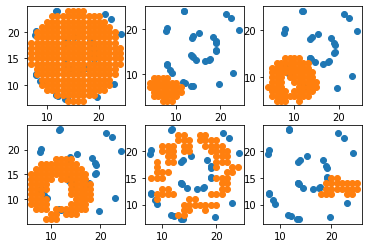

In [ ]:
from trimesh.util import zero_pad

# sample random point on zero-isoline of the doughnut.
x = sample_2D_grid(hyper_params["grid_size"])
zero_point = sdf_2_circle_0(hyper_params["grid_size"])
zero_point_x = zero_point[:,0] * hyper_params["grid_size"]
zero_point_y = zero_point[:,1] * hyper_params["grid_size"]




T = [0, 0.3, 0.5, 0.7, 1, 1.4]
figure, axis = plt.subplots(2, 3)

for t in range(3):
  out = model.forward(params, np.array([T[t]]), x)
  temp = out.reshape(hyper_params['grid_size'],hyper_params['grid_size']) <= 0

  result = onp.where(temp == True)
  xx = result[0] 
  yy = result[1]
  axis[0, t].scatter(zero_point_x, zero_point_y) 
  axis[0, t].scatter(xx, yy)
for t in range(3):
  out = model.forward(params, np.array([T[t + 3]]), x)
  temp = out.reshape(hyper_params['grid_size'],hyper_params['grid_size']) <= 0

  result = onp.where(temp == True)
  xx = result[0] 
  yy = result[1]
  axis[1, t].scatter(zero_point_x, zero_point_y) 
  axis[1, t].scatter(xx, yy)


##Lipschitz Regularization(2D)

100%|██████████| 20000/20000 [01:52<00:00, 178.37it/s, loss=0.013262096]


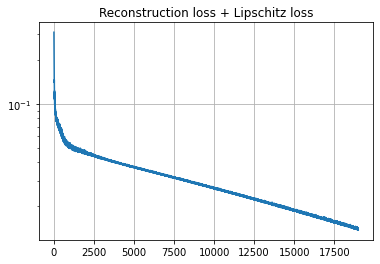

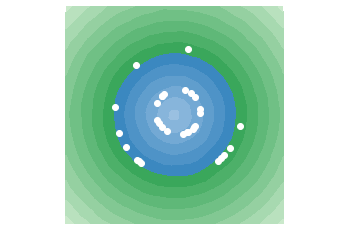

In [ ]:
from jax.example_libraries import optimizers
if __name__ == '__main__':
  random.seed(1)

  # hyper parameters
  hyper_params = {
    "dim_in": 2,
    "dim_t": 1,
    "dim_out": 1,
    "h_mlp": [64,64,64,64],
    "step_size": 1e-4,
    "grid_size": 32,
    "num_epochs": 20000,
    "samples_per_epoch": 512
  }
  alpha = 1e-6

  # initialize a mlp
  model = lipmlp(hyper_params)
  params = model.initialize_weights()

  # optimizer
  opt_init, opt_update, get_params = optimizers.adam(step_size=hyper_params["step_size"])
  opt_state = opt_init(params)

  # define loss function and update function
  def loss(params_, alpha, x_, y0_, y1_):
    out0 = model.forward(params_, np.array([0.0]), x_) # star when t = 0.0
    out1 = model.forward(params_, np.array([1.0]), x_) # circle when t = 1.0
    loss_sdf = np.mean((out0 - y0_)**2) + np.mean((out1 - y1_)**2)
    loss_lipschitz = model.get_lipschitz_loss(params_)
    return loss_sdf + alpha * loss_lipschitz

  @jit
  def update(epoch, opt_state, alpha, x_, y0_, y1_):
    params_ = get_params(opt_state)
    value, grads = value_and_grad(loss, argnums = 0)(params_, alpha, x_, y0_, y1_)
    opt_state = opt_update(epoch, grads, opt_state)
    return value, opt_state

  # training
  loss_history = onp.zeros(hyper_params["num_epochs"])
  pbar = tqdm.tqdm(range(hyper_params["num_epochs"]))
  for epoch in pbar:
    # sample a bunch of random points
    x = np.array(random.rand(hyper_params["samples_per_epoch"], hyper_params["dim_in"]))
    y0 = sdf_circle(x)
    y1 = sdf_2_circle(x)

    # update
    loss_value, opt_state = update(epoch, opt_state, alpha, x, y0, y1)
    loss_history[epoch] = loss_value
    pbar.set_postfix({"loss": loss_value})

    if epoch % 1000 == 0: # plot loss history every 1000 iter
      plt.close(1)
      plt.figure(1)
      plt.semilogy(loss_history[:epoch])
      plt.title('Reconstruction loss + Lipschitz loss')
      plt.grid()
      plt.savefig("lipschitz_mlp_loss_history.jpg")

  # save final parameters
  params = get_params(opt_state)
  with open("lipschitz_mlp_params.pkl", 'wb') as handle:
    pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)
  

  # normalize weights during test time
  params_final = model.normalize_params(params)

  # save result as a video
  sdf_cm = mpl.colors.LinearSegmentedColormap.from_list('SDF', [(0,'#eff3ff'),(0.5,'#3182bd'),(0.5,'#31a354'),(1,'#e5f5e0')], N=256)

  x = sample_2D_grid(hyper_params["grid_size"])
  zero_point = sdf_2_circle_0(hyper_params["grid_size"])
  zero_point_x = zero_point[:,0] * hyper_params["grid_size"]
  zero_point_y = zero_point[:,1] * hyper_params["grid_size"]
  

  # create video
  fig = plt.figure()
  x = sample_2D_grid(hyper_params["grid_size"]) # sample on unit grid for visualization
  def animate(t):
      plt.cla()
      out = model.forward(params, np.array([t]), x)
      levels = onp.linspace(-0.5, 0.5, 21)
      im = plt.contourf(out.reshape(hyper_params['grid_size'],hyper_params['grid_size']), levels = levels, cmap=sdf_cm)
      plt.scatter(zero_point_x, zero_point_y, c = "#FFFFFF")
      plt.axis('equal')
      plt.axis("off")
      return im
  anim = animation.FuncAnimation(fig, animate, frames=np.linspace(0, 1, 50), interval=50)
  anim.save("lipschitz_mlp_interpolation.mp4")

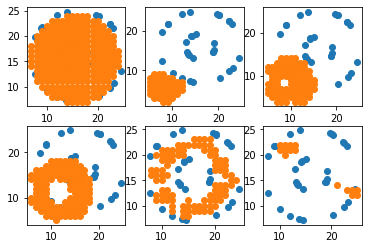

In [ ]:
from trimesh.util import zero_pad

# sample random point on zero-isoline of the donut.
x = sample_2D_grid(hyper_params["grid_size"])
zero_point = sdf_2_circle_0(hyper_params["grid_size"])
zero_point_x = zero_point[:,0] * hyper_params["grid_size"]
zero_point_y = zero_point[:,1] * hyper_params["grid_size"]



T = [0, 0.3, 0.5, 0.7, 1, 1.4]
figure, axis = plt.subplots(2, 3)

for t in range(3):
  out = model.forward(params, np.array([T[t]]), x)
  temp = out.reshape(hyper_params['grid_size'],hyper_params['grid_size']) <= 0

  result = onp.where(temp == True)
  xx = result[0] 
  yy = result[1]
  axis[0, t].scatter(zero_point_x, zero_point_y) 
  axis[0, t].scatter(xx, yy)
for t in range(3):
  out = model.forward(params, np.array([T[t + 3]]), x)
  temp = out.reshape(hyper_params['grid_size'],hyper_params['grid_size']) <= 0

  result = onp.where(temp == True)
  xx = result[0] 
  yy = result[1]
  axis[1, t].scatter(zero_point_x, zero_point_y) 
  axis[1, t].scatter(xx, yy)


##Analysis
Instead of using the image (start and circle) shown in the paper, in this case setting y0 as a circle and y1 as a doughnut (circle with hole). 

With the same hyperparameters, the training time is approximately  slightly longer in Lipschitz regulation than the normal MLP.

Compare with 6 intermediate time step t = [0, 0.3, 0.5, 0.7, 1, 1.4], the Lipschitz regulation MLP has a higher performance as orange points (reconstruction 2d point cloud) are more condense and the shape is quite similar with the doughnut. And for the time step t = 1 the shape is fairly close to the blue points (sample on zero signed distance of the doughnut). However, for time after t = 1, the result is not smooth as the previous time steps which is different with the paper's result.


 


#Lipschitz Regularization(3D)
Now, tranning and testing in 3D dimension and with complex shape. 

In [ ]:
!gdown 1Ahv8D8LuHKDryauQzo0rdfoHZYeZBGNm

Downloading...
From: https://drive.google.com/uc?id=1Ahv8D8LuHKDryauQzo0rdfoHZYeZBGNm
To: /content/chair.obj
100% 350k/350k [00:00<00:00, 146MB/s]


In [ ]:
# for training with chair
# change y0 and y1 in training part
#y0 = trimesh.proximity.signed_distance(chair1, x)
#y1 = trimesh.proximity.signed_distance(chair2, x) 
import trimesh 
chair1 = trimesh.load("/content/chair.obj")
chair2 = trimesh.load("/content/chair.obj")
chair2 = chair2.apply_scale(1.0 / chair2.extents * onp.min(chair2.extents))


###training

100%|██████████| 20000/20000 [04:09<00:00, 80.20it/s, loss=0.013412837]


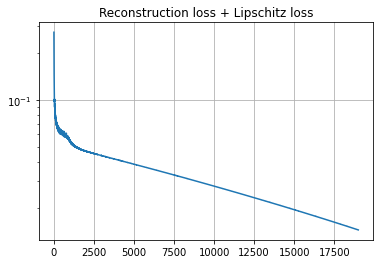

In [ ]:
from jax.example_libraries import optimizers
if __name__ == '__main__':
  random.seed(1)

  # hyper parameters
  hyper_params = {
    "dim_in": 3,
    "dim_t": 1,
    "dim_out": 1,
    "h_mlp": [64,64,64,64],
    "step_size": 1e-4,
    "grid_size": 32,
    "num_epochs": 20000,
    "samples_per_epoch": 512
  }
  alpha = 1e-6

  # initialize a mlp
  model = lipmlp(hyper_params)
  params = model.initialize_weights()

  # optimizer
  opt_init, opt_update, get_params = optimizers.adam(step_size=hyper_params["step_size"])
  opt_state = opt_init(params)

  # define loss function and update function
  def loss(params_, alpha, x_, y0_, y1_):
    out0 = model.forward(params_, np.array([0.0]), x_) # star when t = 0.0
    out1 = model.forward(params_, np.array([1.0]), x_) # circle when t = 1.0
    loss_sdf = np.mean((out0 - y0_)**2) + np.mean((out1 - y1_)**2)
    loss_lipschitz = model.get_lipschitz_loss(params_)
    return loss_sdf + alpha * loss_lipschitz

  @jit
  def update(epoch, opt_state, alpha, x_, y0_, y1_):
    params_ = get_params(opt_state)
    value, grads = value_and_grad(loss, argnums = 0)(params_, alpha, x_, y0_, y1_)
    opt_state = opt_update(epoch, grads, opt_state)
    return value, opt_state

  # training
  loss_history = onp.zeros(hyper_params["num_epochs"])
  pbar = tqdm.tqdm(range(hyper_params["num_epochs"]))
  for epoch in pbar:
    # sample a bunch of random points
    x = np.array(random.rand(hyper_params["samples_per_epoch"], hyper_params["dim_in"]))
    y0 = sdf_sphere(x)
    y1 = sdf_torus(x)
    #y0 = trimesh.proximity.signed_distance(chair1, x)
    #y1 = trimesh.proximity.signed_distance(chair2, x)


    # update
    loss_value, opt_state = update(epoch, opt_state, alpha, x, y0, y1)
    loss_history[epoch] = loss_value
    pbar.set_postfix({"loss": loss_value})

    if epoch % 1000 == 0: # plot loss history every 1000 iter
      plt.close(1)
      plt.figure(1)
      plt.semilogy(loss_history[:epoch])
      plt.title('Reconstruction loss + Lipschitz loss')
      plt.grid()
      plt.savefig("lipschitz_mlp_loss_history_3d.jpg")

  # save final parameters
  params = get_params(opt_state)
  with open("lipschitz_mlp_params_3d.pkl", 'wb') as handle:
    pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)



Change t to see the result in different time step

In [ ]:
from numpy import savetxt
from google.colab import files
import skimage.measure
from numpy import loadtxt
import trimesh
import pyrender


# normalize weights during test time
params_final = model.normalize_params(params)

t = 1
x = sample_3D_grid(100, low = 0, high = 1)
out = model.forward_eval(params_final, np.array([t]), x)
voxels = out
voxels = onp.reshape(voxels, (100, 100, 100))
voxels = onp.array(voxels)
vertices, faces, normals, _ = skimage.measure.marching_cubes(voxels, level=0)
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, vertex_normals=normals)

mesh.show()

###testing 

In [ ]:
# To exam the smoothness
# can simply use igl::hausdorff(VA,FA,VB,FB,d)
# However igl does not work perfectly on colab. 
def hausdorff_distance(verticesA, verticesB):
  h = 0
  for i in range(verticesA.shape[0]):
    shortest = onp.inf
    for j in range(verticesB.shape[0]):
      d = onp.linalg.norm(verticesA[i, :] - verticesB[j, :])
      if d < shortest:
        shortest = d
    if shortest > h:
      h = shortest
  return h

In [ ]:
!mkdir output

mkdir: cannot create directory ‘output’: File exists


In [ ]:

from google.colab import files
import skimage.measure
from numpy import loadtxt
import trimesh
import pyrender

# normalize weights during test time
params_final = model.normalize_params(params)


T = []
t = 0 
distance = []
while t + 0.1 < 1.3:
  x = sample_3D_grid(30, low = 0, high = 1)
  out = model.forward_eval(params_final, np.array([t]), x)
  voxels = out
  voxels = onp.reshape(voxels, (30, 30, 30))
  voxels = onp.array(voxels)
  vertices1, faces1, normals1, _ = skimage.measure.marching_cubes(voxels, level=0)
  mesh = trimesh.Trimesh(vertices=vertices1, faces=faces1, vertex_normals=normals1)
  mesh.export(file_type="obj", file_obj = "output/" + str(round(t, 2)) + "output.obj")


 
  out = model.forward_eval(params_final, np.array([t + 0.1]), x)
  voxels = out
  voxels = onp.reshape(voxels, (30, 30, 30))
  voxels = onp.array(voxels)
  vertices2, faces2, normals2, _ = skimage.measure.marching_cubes(voxels, level=0)

  d = hausdorff_distance(vertices1, vertices2)
  distance.append(d)
  T.append(t)
  t = t + 0.1
  


  
 


[2.4190397, 3.6375647, 5.5099864, 6.3162575, 2.1691651, 2.7724419, 2.9763103, 3.5666423, 4.1075616, 4.1930456, 4.4311795, 12.981321]


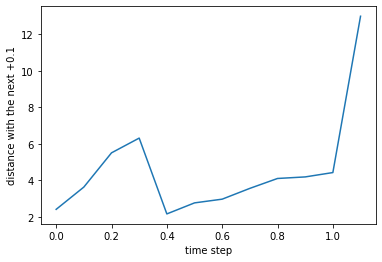

In [ ]:
plt.xlabel("time step")
plt.ylabel("distance with the next +0.1")  
print(distance)
plt.plot(T, distance) 
plt.show()

In [ ]:
from google.colab import files
import pandas as pd
!zip -r /content/output.zip /content/output
files.download('output.zip')

updating: content/output/ (stored 0%)
updating: content/output/0.9999999999999999output.obj (deflated 70%)
updating: content/output/1.0output.obj (deflated 70%)
updating: content/output/0.7output.obj (deflated 71%)
updating: content/output/1.1output.obj (deflated 70%)
updating: content/output/0.2output.obj (deflated 71%)
updating: content/output/0output.obj (deflated 71%)
updating: content/output/0.4output.obj (deflated 70%)
updating: content/output/0.6output.obj (deflated 71%)
updating: content/output/0.5output.obj (deflated 70%)
updating: content/output/0.9output.obj (deflated 71%)
updating: content/output/0.1output.obj (deflated 71%)
updating: content/output/0.3output.obj (deflated 71%)
updating: content/output/0.8999999999999999output.obj (deflated 71%)
updating: content/output/0.8output.obj (deflated 71%)
updating: content/output/1.0999999999999999output.obj (deflated 70%)
  adding: content/output/.ipynb_checkpoints/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Analysis
For simple shape transformation like a sphere to the torus. The shape is correctly transformed and with a smooth intermediate shape for each time step. However when t > 1, the difference between each time step increases dramatically, and the smoothness does not maintain after t > 1. For the time after 1, then the performance is not the same as the paper stated. 

And with complex shapes like the chair, the result is terrible, possibly because of the small numbers of training epochs (only run 20000 steps in collab). 

#Compare with k-Lipschitz constrained networks

Instead of normal MLP, I still want to explore its performance when compare to other MLP method. 

There are several MLP mentioned in paper, such as Lipschitz constrained networks, and add Dirichlet energy to the loss function, etc. 

Since different tasks require different Lipschitz constants. For circle to donut, the appropriate constant is 2. With constant 1, the performance is really bad. 



The loss function is, 
\begin{align}
L = L(normal MLP) + α * \prod||W_i||_∞
\end{align}


## Model

In [ ]:
import sys
sys.path.append('../../../')


import jax
import jax.numpy as np
from jax import jit, value_and_grad


import numpy as onp
import numpy.random as random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tqdm
import pickle
from numpy import linalg as LA
class lip_k_mlp:
  def __init__(self, hyperParams):
    self.hyperParams = hyperParams
  
  def initialize_weights(self):
    """
    Initialize the parameters of the Lipschitz mlp
    Inputs
    hyperParams: hyper parameter dictionary
    Outputs
    params_net: parameters of the network (weight, bias, initial lipschitz bound)
    """
    def init_W(size_out, size_in): 
        W = onp.random.randn(size_out, size_in) * onp.sqrt(2 / size_in)
        return np.array(W)
    sizes = self.hyperParams["h_mlp"]
    sizes.insert(0, self.hyperParams["dim_in"] + self.hyperParams["dim_t"])
    sizes.append(self.hyperParams["dim_out"])
    params_net = []    
    for ii in range(len(sizes) - 1):
        W = init_W(sizes[ii+1], sizes[ii])
        b = np.zeros(sizes[ii+1])

        params_net.append([W, b])
    return params_net

  def weight_normalization(self, W):
    """
    Lipschitz weight normalization based on the L-infinity norm
    """
    absrowsum = np.sum(np.abs(W), axis=1)
    scale = np.minimum(self.hyperParams["k"], self.hyperParams["k"]/absrowsum)
    return W * scale[:,None]

  def forward_single(self, params_net, t, x):
    """
    Forward pass of a lipschitz MLP
    
    Inputs
    params_net: parameters of the network
    t: the input feature of the shape
    x: a query location in the space
    Outputs
    out: implicit function value at x
    """
    # concatenate coordinate and latent code
    x = np.append(x, t)

    # forward pass
    for ii in range(len(params_net) - 1):
        W, b= params_net[ii]
        W = self.weight_normalization(W)
        x = jax.nn.relu(np.dot(W, x) + b)

    # final layer
    W, b = params_net[-1]
    W = self.weight_normalization(W) 
    out = np.dot(W, x) + b
    return out[0]
  forward = jax.vmap(forward_single, in_axes=(None, None, None, 0), out_axes=0)
  
  
  def get_weight_loss(self, params_net):
    """
    This function computes the softplus loss
    """
    loss_lip = 1.0
    for ii in range(len(params_net)):
      W, b = params_net[ii]
      absrowsum = np.sum(np.abs(W), axis=1)
      loss_lip = loss_lip * np.max(absrowsum)  
    return loss_lip




  def normalize_params(self, params_net):
    """
    (Optional) After training, this function will clip network [W, b] based on learned lipschitz constants. Thus, one can use normal MLP forward pass during test time, which is a little bit faster.
    """
    params_final = []    
    for ii in range(len(params_net)):
      W, b = params_net[ii]
      W = self.weight_normalization(W)
      params_final.append([W, b])
    return params_final

  def forward_eval_single(self, params_final, t, x):
    """
    (Optional) this is a standard forward pass of a mlp. This is useful to speed up the performance during test time 
    """
    # concatenate coordinate and latent code
    x = np.append(x, t)

    # forward pass
    for ii in range(len(params_final) - 1):
        W, b = params_final[ii]
        x = jax.nn.relu(np.dot(W, x) + b)
    W, b = params_final[-1] # final layer
    out = np.dot(W, x) + b
    return out[0]
  forward_eval = jax.vmap(forward_eval_single, in_axes=(None, None, None, 0), out_axes=0)

## k-Lipschitz constrained networks(2D)

100%|██████████| 20000/20000 [01:50<00:00, 181.69it/s, loss=0.0022074229]


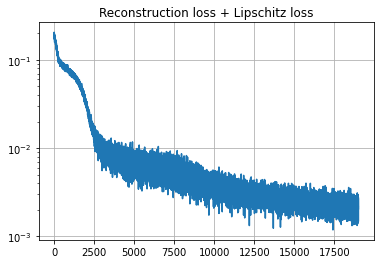

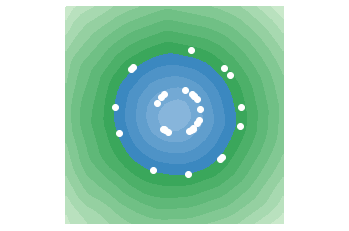

In [ ]:
from jax.example_libraries import optimizers
if __name__ == '__main__':
  random.seed(1)

  # hyper parameters
  hyper_params = {
    "dim_in": 2,
    "dim_t": 1,
    "dim_out": 1,
    "h_mlp": [64,64,64,64],
    "step_size": 1e-4,
    "grid_size": 32,
    "num_epochs": 20000,
    "samples_per_epoch": 512,
    "k":2
  }
  alpha = 1e-6

  # initialize a mlp
  model = lip_k_mlp(hyper_params)
  params = model.initialize_weights()

  # optimizer
  opt_init, opt_update, get_params = optimizers.adam(step_size=hyper_params["step_size"])
  opt_state = opt_init(params)

  # define loss function and update function
  def loss(params_, alpha, x_, y0_, y1_):
    out0 = model.forward(params_, np.array([0.0]), x_) # star when t = 0.0
    out1 = model.forward(params_, np.array([1.0]), x_) # circle when t = 1.0
    loss_sdf = np.mean((out0 - y0_)**2) + np.mean((out1 - y1_)**2)
    weight_loss = model.get_weight_loss(params_)
    return loss_sdf + alpha * weight_loss

  @jit
  def update(epoch, opt_state, alpha, x_, y0_, y1_):
    params_ = get_params(opt_state)
    value, grads = value_and_grad(loss, argnums = 0)(params_, alpha, x_, y0_, y1_)
    opt_state = opt_update(epoch, grads, opt_state)
    return value, opt_state

  # training
  loss_history = onp.zeros(hyper_params["num_epochs"])
  pbar = tqdm.tqdm(range(hyper_params["num_epochs"]))
  for epoch in pbar:
    # sample a bunch of random points
    x = np.array(random.rand(hyper_params["samples_per_epoch"], hyper_params["dim_in"]))
    y0 = sdf_circle(x)
    y1 = sdf_2_circle(x)

    # update
    loss_value, opt_state = update(epoch, opt_state, alpha, x, y0, y1)
    loss_history[epoch] = loss_value
    pbar.set_postfix({"loss": loss_value})

    if epoch % 1000 == 0: # plot loss history every 1000 iter
      plt.close(1)
      plt.figure(1)
      plt.semilogy(loss_history[:epoch])
      plt.title('Reconstruction loss + Lipschitz loss')
      plt.grid()
      plt.savefig("lip_k_mlp_loss_history.jpg")

  # save final parameters
  params = get_params(opt_state)
  with open("lip_k_mlp_params.pkl", 'wb') as handle:
    pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)
  

  # normalize weights during test time
  params_final = model.normalize_params(params)

  # save result as a video
  sdf_cm = mpl.colors.LinearSegmentedColormap.from_list('SDF', [(0,'#eff3ff'),(0.5,'#3182bd'),(0.5,'#31a354'),(1,'#e5f5e0')], N=256)

  x = sample_2D_grid(hyper_params["grid_size"])
  zero_point = sdf_2_circle_0(hyper_params["grid_size"])
  zero_point_x = zero_point[:,0] * hyper_params["grid_size"]
  zero_point_y = zero_point[:,1] * hyper_params["grid_size"]
  

  # create video
  fig = plt.figure()
  x = sample_2D_grid(hyper_params["grid_size"]) # sample on unit grid for visualization
  def animate(t):
      plt.cla()
      out = model.forward(params, np.array([t]), x)
      levels = onp.linspace(-0.5, 0.5, 21)
      im = plt.contourf(out.reshape(hyper_params['grid_size'],hyper_params['grid_size']), levels = levels, cmap=sdf_cm)
      plt.scatter(zero_point_x, zero_point_y, c = "#FFFFFF")
      plt.axis('equal')
      plt.axis("off")
      return im
  anim = animation.FuncAnimation(fig, animate, frames=np.linspace(0, 1, 50), interval=50)
  anim.save("lip_k_mlp_interpolation.mp4")

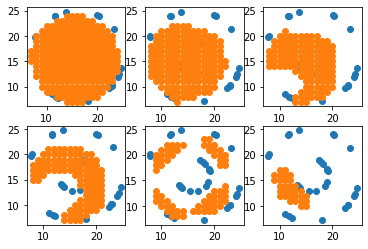

In [ ]:
from trimesh.util import zero_pad

# sample random point on zero-isoline of the donut.
x = sample_2D_grid(hyper_params["grid_size"])
zero_point = sdf_2_circle_0(hyper_params["grid_size"])
zero_point_x = zero_point[:,0] * hyper_params["grid_size"]
zero_point_y = zero_point[:,1] * hyper_params["grid_size"]



T = [0, 0.3, 0.5, 0.7, 1, 1.4]
figure, axis = plt.subplots(2, 3)

for t in range(3):
  out = model.forward(params, np.array([T[t]]), x)
  temp = out.reshape(hyper_params['grid_size'],hyper_params['grid_size']) <= 0

  result = onp.where(temp == True)
  xx = result[0] 
  yy = result[1]
  axis[0, t].scatter(zero_point_x, zero_point_y) 
  axis[0, t].scatter(xx, yy)
for t in range(3):
  out = model.forward(params, np.array([T[t + 3]]), x)
  temp = out.reshape(hyper_params['grid_size'],hyper_params['grid_size']) <= 0

  result = onp.where(temp == True)
  xx = result[0] 
  yy = result[1]
  axis[1, t].scatter(zero_point_x, zero_point_y) 
  axis[1, t].scatter(xx, yy)


##Analysis
Though the orange points are dense, the shape is not correctly doughnut shape. and when t = 1, the shape is slightly incorrect. However, when t > 1, the transit shape is more smooth than the normal MLP and the Lipschitz Regulation. The reason why both Lipschitz Regulation and k-Lipschitz have condensed point clouds in test-time reconstruction is that they will not suffer from poor local minimum (MLP). And this result is same as with the paper. 

Though the performance of the k-Lipschitz constrained network has good performance, it is really hard to find a correct Lipschitz constant. 

##k-Lipschitz constrained networks(3D)

###training

100%|██████████| 20000/20000 [04:09<00:00, 80.13it/s, loss=0.00024971075]


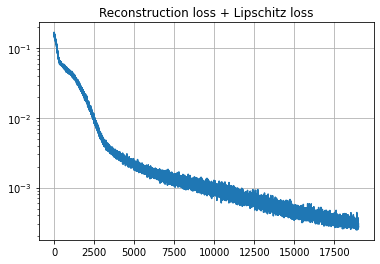

In [ ]:
from jax.example_libraries import optimizers
if __name__ == '__main__':
  random.seed(1)

  # hyper parameters
  hyper_params = {
    "dim_in": 3,
    "dim_t": 1,
    "dim_out": 1,
    "h_mlp": [64,64,64,64],
    "step_size": 1e-4,
    "grid_size": 32,
    "num_epochs": 20000,
    "samples_per_epoch": 512,
    "k":2
  }
  alpha = 1e-6

  # initialize a mlp
  model = lip_k_mlp(hyper_params)
  params = model.initialize_weights()

  # optimizer
  opt_init, opt_update, get_params = optimizers.adam(step_size=hyper_params["step_size"])
  opt_state = opt_init(params)

  # define loss function and update function
  def loss(params_, alpha, x_, y0_, y1_):
    out0 = model.forward(params_, np.array([0.0]), x_) # star when t = 0.0
    out1 = model.forward(params_, np.array([1.0]), x_) # circle when t = 1.0
    loss_sdf = np.mean((out0 - y0_)**2) + np.mean((out1 - y1_)**2)
    weight_loss = model.get_weight_loss(params_)
    return loss_sdf + alpha * weight_loss

  @jit
  def update(epoch, opt_state, alpha, x_, y0_, y1_):
    params_ = get_params(opt_state)
    value, grads = value_and_grad(loss, argnums = 0)(params_, alpha, x_, y0_, y1_)
    opt_state = opt_update(epoch, grads, opt_state)
    return value, opt_state

  # training
  loss_history = onp.zeros(hyper_params["num_epochs"])
  pbar = tqdm.tqdm(range(hyper_params["num_epochs"]))
  for epoch in pbar:
    # sample a bunch of random points
    x = np.array(random.rand(hyper_params["samples_per_epoch"], hyper_params["dim_in"]))
    y0 = sdf_sphere(x)
    y1 = sdf_torus(x)

    # update
    loss_value, opt_state = update(epoch, opt_state, alpha, x, y0, y1)
    loss_history[epoch] = loss_value
    pbar.set_postfix({"loss": loss_value})

    if epoch % 1000 == 0: # plot loss history every 1000 iter
      plt.close(1)
      plt.figure(1)
      plt.semilogy(loss_history[:epoch])
      plt.title('Reconstruction loss + Lipschitz loss')
      plt.grid()
      plt.savefig("lip_k_mlp_loss_history3d.jpg")

  # save final parameters
  params = get_params(opt_state)
  with open("lip_k_mlp_params3d.pkl", 'wb') as handle:
    pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)


###testing

In [ ]:
from numpy import savetxt
# normalize weights during test time
params_final = model.normalize_params(params)
from google.colab import files
import skimage.measure
from numpy import loadtxt
import trimesh
import pyrender

t = 1
x = sample_3D_grid(100, low = 0, high = 1)
out = model.forward_eval(params_final, np.array([t]), x)
voxels = out
voxels = onp.reshape(voxels, (100, 100, 100))
voxels = onp.array(voxels)
vertices, faces, normals, _ = skimage.measure.marching_cubes(voxels, level=0)
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, vertex_normals=normals)

mesh.show()

In [ ]:
!mkdir output2

mkdir: cannot create directory ‘output2’: File exists


In [ ]:
from google.colab import files
import skimage.measure
from numpy import loadtxt
import trimesh
import pyrender

# normalize weights during test time
params_final = model.normalize_params(params)


T = []
t = 0 
distance = []
while t + 0.1 < 1.3:
  x = sample_3D_grid(30, low = 0, high = 1)
  out = model.forward_eval(params_final, np.array([t]), x)
  voxels = out
  voxels = onp.reshape(voxels, (30, 30, 30))
  voxels = onp.array(voxels)
  vertices1, faces1, normals1, _ = skimage.measure.marching_cubes(voxels, level=0)
  mesh = trimesh.Trimesh(vertices=vertices1, faces=faces1, vertex_normals=normals1)
  mesh.export(file_type="obj", file_obj = "output2/" + str(round(t, 2)) + "output.obj")


 
  out = model.forward_eval(params_final, np.array([t + 0.1]), x)
  voxels = out
  voxels = onp.reshape(voxels, (30, 30, 30))
  voxels = onp.array(voxels)
  vertices2, faces2, normals2, _ = skimage.measure.marching_cubes(voxels, level=0)

  d = hausdorff_distance(vertices1, vertices2)
  distance.append(d)
  T.append(t)
  t = t + 0.1
  


  

[1.1086882, 0.97137237, 0.85892105, 1.0054455, 1.430809, 1.4763088, 1.9473875, 2.1392262, 2.6587296, 3.5414352, 4.2488213, 14.981661]


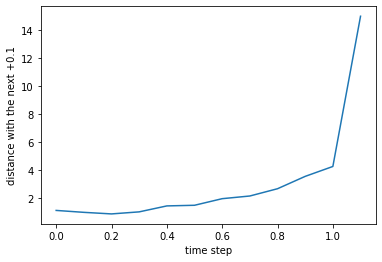

In [ ]:
plt.xlabel("time step")
plt.ylabel("distance with the next +0.1")  
print(distance)
plt.plot(T, distance) 
plt.show()

In [ ]:
from google.colab import files
import pandas as pd
!zip -r /content/output2.zip /content/output2
files.download('output2.zip')


updating: content/output2/ (stored 0%)
updating: content/output2/1.0output.obj (deflated 70%)
updating: content/output2/0.7output.obj (deflated 71%)
updating: content/output2/1.1output.obj (deflated 69%)
updating: content/output2/0.2output.obj (deflated 71%)
updating: content/output2/0output.obj (deflated 71%)
updating: content/output2/0.4output.obj (deflated 71%)
updating: content/output2/0.6output.obj (deflated 71%)
updating: content/output2/0.5output.obj (deflated 71%)
updating: content/output2/.ipynb_checkpoints/ (stored 0%)
updating: content/output2/0.9output.obj (deflated 71%)
updating: content/output2/0.1output.obj (deflated 71%)
updating: content/output2/0.3output.obj (deflated 71%)
updating: content/output2/0.8output.obj (deflated 71%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Analysis (compare with Lipschitz Regularization)
For t <= 1, the distance between two close time step even smaller compare with the Lipschitz Regulation. And for t > 1, the distance is as worse as the Lipschitz regularization MLP. However the overall performance is better. 

The training time is slightly larger than the Lipschitz regularization MLP. Which is 80.20iterations/s < 80.13iterations/s

For training larger networks, the time will be much more slower than LIpschitz regularization MLP. 



#Furthur Improvement(or difficultity I faced)
I found a really hard time in implement this model in complicated 3D shape. The result is not as good as simple 3D shape. 

And this only part of experiment. It only compare with normal MLP and k-Lipschitz constrained networks. More comparsion need to be done with other MLP algorithmn. 
Though paper mentions " Our method only encourages smooth interpolation. Thus our method cannot extract high-level information, such as semantics, from only a handful of shapes." I am still curious about if it can be used in morphing the shape. 

For visualization, I am still struggling with putting all objects in one scene or creating video based on those objects. 



#Conclusion
Overall, the Lipschitz Regularization method has a better performance in both 2D and 3D. Nevertheless, the smoothness is not maintained for extrapolation (t > 1).  

There is not much improvement compared to k-Lipschitz-constrained networks under thoses experiments. However, Lipschitz Regularization saves time and effort in finding correct Lipschitz constant k (in hyper parameters). 

